In [ ]:
import os
import glob
import torch
import pickle
import random
import logging
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import tensorflow as tf
from shutil import copyfile
import torch.optim as optim
from google.colab import files
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import defaultdict
from torch.utils.data import Dataset
from sklearn.metrics import log_loss
from scipy.stats import skew, kurtosis
from sklearn.model_selection import KFold
from tensorflow.keras import layers, models
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

logging.basicConfig(level=logging.INFO)

In [ ]:
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bgu-i-cant-see-you-but-you-are-reading-a-book
with zipfile.ZipFile("/content/bgu-i-cant-see-you-but-you-are-reading-a-book.zip", "r") as zip_ref:
    zip_ref.extractall("i_cant_see")

Saving kaggle.json to kaggle.json
100% 4.98G/4.98G [00:53<00:00, 92.2MB/s]
100% 4.98G/4.98G [00:53<00:00, 99.9MB/s]


#carite the table stastic

In [ ]:
# Base file path
base_path = data_dir

# Function to calculate statistics for each measurement type
from sklearn.preprocessing import StandardScaler

import numpy as np
from scipy.signal import find_peaks
from scipy.fft import fft
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf

def calculate_statistics(df, measurement_type):
    # Filter the data for the given measurement type
    subset = df[df['measurement type'] == measurement_type].copy()  # Make an explicit copy

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Calculate the main statistics
    stats = subset[['x', 'y', 'z']].agg(['mean', 'std', 'min', 'max', 'median', 'skew', 'var', 'kurt']).T

    # Calculate the range for each axis
    stats['range'] = stats['max'] - stats['min']

    # Add correlations between the axes (x, y, z)
    stats['correlation_xy'] = subset[['x', 'y']].corr().iloc[0, 1]  # Correlation between x and y
    stats['correlation_xz'] = subset[['x', 'z']].corr().iloc[0, 1]  # Correlation between x and z
    stats['correlation_yz'] = subset[['y', 'z']].corr().iloc[0, 1]  # Correlation between y and z

    # Add the mean squared values for each axis (useful for understanding the magnitude of data)
    stats['mean_squared_x'] = (subset['x'] ** 2).mean()
    stats['mean_squared_y'] = (subset['y'] ** 2).mean()
    stats['mean_squared_z'] = (subset['z'] ** 2).mean()

    # Calculate skewness and kurtosis for combined data
    stats['combined_skew'] = subset[['x', 'y', 'z']].stack().skew()
    stats['combined_kurtosis'] = subset[['x', 'y', 'z']].stack().kurtosis()

    # **Additional Features**:

    # **RMS (Root Mean Square)**
    stats['rms_x'] = np.sqrt(np.mean(subset['x'] ** 2))
    stats['rms_y'] = np.sqrt(np.mean(subset['y'] ** 2))
    stats['rms_z'] = np.sqrt(np.mean(subset['z'] ** 2))

    # **Slope of the trend line (linear regression slope)**
    from sklearn.linear_model import LinearRegression
    X = np.arange(len(subset)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, subset['x'])
    stats['slope_x'] = lr.coef_[0]
    lr.fit(X, subset['y'])
    stats['slope_y'] = lr.coef_[0]
    lr.fit(X, subset['z'])
    stats['slope_z'] = lr.coef_[0]

    # **Time-to-Peak**: Time it takes to reach the peak for each axis (find the first local maximum)
    stats['time_to_peak_x'] = np.argmax(subset['x']) / len(subset)
    stats['time_to_peak_y'] = np.argmax(subset['y']) / len(subset)
    stats['time_to_peak_z'] = np.argmax(subset['z']) / len(subset)

    # **Autocorrelation**: Autocorrelation at lag 1 (measure of self-similarity over time)
    def autocorrelation(signal, lag=1):
        # Calculate autocorrelation using ACF (AutoCorrelation Function) from statsmodels
        return acf(signal, nlags=lag)[lag]

    stats['autocorr_x'] = autocorrelation(subset['x'], lag=1)
    stats['autocorr_y'] = autocorrelation(subset['y'], lag=1)
    stats['autocorr_z'] = autocorrelation(subset['z'], lag=1)

    # **Jerk**: The derivative of acceleration (i.e., the rate of change of acceleration)
    stats['jerk_x'] = np.diff(subset['x'], n=2).mean()
    stats['jerk_y'] = np.diff(subset['y'], n=2).mean()
    stats['jerk_z'] = np.diff(subset['z'], n=2).mean()



    # **Peak Features**: Find the number of peaks in each axis
    def peak_count(signal):
        peaks, _ = find_peaks(signal)
        return len(peaks)

    stats['peak_count_x'] = peak_count(subset['x'])
    stats['peak_count_y'] = peak_count(subset['y'])
    stats['peak_count_z'] = peak_count(subset['z'])

    # Add the measurement type as a column for context
    stats['measurement type'] = measurement_type

    return stats




# Initialize an empty list to store all results
all_results = []

# Loop through each ID and process the corresponding file
for id_value in df_smartwatch_x['id']:
    file_path = os.path.join(base_path, f"{id_value}.csv")

    # Read the CSV file
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        # List of unique measurement types
        measurement_types = df['measurement type'].unique()

        # Compute stats for each measurement type
        id_results = []
        for measurement_type in measurement_types:
            stats = calculate_statistics(df, measurement_type)
            stats['id'] = id_value  # Add the ID for reference
            id_results.append(stats)

        # Combine results for this ID
        id_combined_results = pd.concat(id_results)
        # print(id_combined_results.columns)
        all_results.append(id_combined_results)
    else:
        print(f"File not found: {file_path}")

# Combine all results into a single DataFrame
final_smartwatch_results = pd.concat(all_results).reset_index()
final_smartwatch_results = final_smartwatch_results[['id', 'measurement type', 'index','mean', 'std', 'min', 'max', 'median', 'skew', 'var', 'kurt', 'range',
       'correlation_xy', 'correlation_xz', 'correlation_yz', 'mean_squared_x',
       'mean_squared_y', 'mean_squared_z', 'combined_skew',
       'combined_kurtosis', 'rms_x', 'rms_y', 'rms_z', 'slope_x', 'slope_y',
       'slope_z', 'time_to_peak_x', 'time_to_peak_y', 'time_to_peak_z',
       'autocorr_x', 'autocorr_y', 'autocorr_z', 'jerk_x', 'jerk_y', 'jerk_z',
        'peak_count_x',
       'peak_count_y', 'peak_count_z']]
# Display the final results
print(final_smartwatch_results)

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

def calculate_vicon_statistics(df):
    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Normalize x [m], y [m], z [m] using StandardScaler
    # scaled_values = scaler.fit_transform(df[['x [m]', 'y [m]', 'z [m]']])
    normalized_df = pd.DataFrame(df[['x [m]', 'y [m]', 'z [m]']],
                                 columns=['x [m]', 'y [m]', 'z [m]'],
                                 index=df.index)     # print(normalized_df.columns)
    # Calculate statistics for normalized x [m], y [m], z [m]
    stats = normalized_df.agg(['mean', 'std', 'min', 'max', 'median', 'skew', 'var', 'kurt']).T

    # Calculate the range (max - min) for each axis
    stats['range'] = stats['max'] - stats['min']

    # **Additional Features**:
    stats['correlation_xy'] = normalized_df[['x [m]', 'y [m]']].corr().iloc[0, 1]  # Correlation between x and y
    stats['correlation_xz'] = normalized_df[['x [m]', 'z [m]']].corr().iloc[0, 1]  # Correlation between x and z
    stats['correlation_yz'] = normalized_df[['y [m]', 'z [m]']].corr().iloc[0, 1]  # Correlation between y and z

    # Add the mean squared values for each axis (useful for understanding the magnitude of data)
    stats['mean_squared_x'] = (normalized_df['x [m]'] ** 2).mean()
    stats['mean_squared_y'] = (normalized_df['y [m]'] ** 2).mean()
    stats['mean_squared_z'] = (normalized_df['z [m]'] ** 2).mean()

    # Calculate skewness and kurtosis for combined data
    stats['combined_skew'] = normalized_df[['x [m]', 'y [m]', 'z [m]']].stack().skew()
    stats['combined_kurtosis'] = normalized_df[['x [m]', 'y [m]', 'z [m]']].stack().kurtosis()
    # **RMS (Root Mean Square)**
    stats['rms_x'] = np.sqrt(np.mean(normalized_df['x [m]'] ** 2))
    stats['rms_y'] = np.sqrt(np.mean(normalized_df['y [m]'] ** 2))
    stats['rms_z'] = np.sqrt(np.mean(normalized_df['z [m]'] ** 2))

    # **Slope of the trend line (linear regression slope)**
    X = np.arange(len(df)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, df['x [m]'])
    stats['slope_x'] = lr.coef_[0]
    lr.fit(X, df['y [m]'])
    stats['slope_y'] = lr.coef_[0]
    lr.fit(X, df['z [m]'])
    stats['slope_z'] = lr.coef_[0]

    # **Time-to-Peak**: Time it takes to reach the peak for each axis (find the first local maximum)
    stats['time_to_peak_x'] = np.argmax(df['x [m]']) / len(df)
    stats['time_to_peak_y'] = np.argmax(df['y [m]']) / len(df)
    stats['time_to_peak_z'] = np.argmax(df['z [m]']) / len(df)

    # **Autocorrelation**: Autocorrelation at lag 1 (measure of self-similarity over time)
    stats['autocorr_x'] = df['x [m]'].autocorr(lag=1)
    stats['autocorr_y'] = df['y [m]'].autocorr(lag=1)
    stats['autocorr_z'] = df['z [m]'].autocorr(lag=1)

    # **Jerk**: The derivative of acceleration (i.e., the rate of change of acceleration)
    stats['jerk_x'] = np.diff(df['x [m]'], n=2).mean()
    stats['jerk_y'] = np.diff(df['y [m]'], n=2).mean()
    stats['jerk_z'] = np.diff(df['z [m]'], n=2).mean()


    def peak_count(signal):
        peaks, _ = find_peaks(signal)
        return len(peaks)

    stats['peak_count_x'] = peak_count(df['x [m]'])
    stats['peak_count_y'] = peak_count(df['y [m]'])
    stats['peak_count_z'] = peak_count(df['z [m]'])

    return stats

# Initialize an empty list to store all results
all_vicon_results = []

# Loop through each ID and process the corresponding file

for id_value in df_vicon_x['id']:
    file_path = os.path.join(base_path, f"{id_value}.csv")

    # Read the CSV file
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

        # Compute stats for Vicon data
        vicon_stats = calculate_vicon_statistics(df)
        vicon_stats['id'] = id_value  # Add the ID for reference
        all_vicon_results.append(vicon_stats)
    else:
        print(f"File not found: {file_path}")

# Combine all results into a single DataFrame
final_vicon_results = pd.concat(all_vicon_results)
vicon_final_results = final_vicon_results[['id','mean', 'std', 'min', 'max', 'median', 'skew', 'var', 'kurt', 'range',
       'correlation_xy', 'correlation_xz', 'correlation_yz', 'mean_squared_x',
       'mean_squared_y', 'mean_squared_z', 'combined_skew',
       'combined_kurtosis', 'rms_x', 'rms_y', 'rms_z', 'slope_x', 'slope_y',
       'slope_z', 'time_to_peak_x', 'time_to_peak_y', 'time_to_peak_z',
       'autocorr_x', 'autocorr_y', 'autocorr_z', 'jerk_x', 'jerk_y', 'jerk_z',
        'peak_count_x',
       'peak_count_y', 'peak_count_z']]
print(final_vicon_results)


In [ ]:
df_train = pd.read_csv('/content/i_cant_see/train.csv')
df_matadata = pd.read_csv('/content/metadata.csv')

df_train_copy = df_train.copy()
df_train_smartwatch_copy = df_train_copy[ ~(df_train_copy['sensor']=='vicon')]
df_train_vicon_copy = df_train_copy[ ~(df_train_copy['sensor']=='smartwatch')]

df_smartwatch = df_train_smartwatch_copy[['id', 'body_part', 'side', 'sequence_length', 'activity']]
df_smartwatch = df_smartwatch.sort_values(by=['id'])
df_vicon = df_train_vicon_copy[['id', 'body_part', 'side', 'sequence_length', 'activity']]
df_vicon = df_vicon.sort_values(by=['id'])

df_smartwatch_x = df_smartwatch.drop(columns=['activity'])
df_vicon_x = df_vicon.drop(columns=['activity'])
df_smartwatch_y = df_smartwatch[['id', 'activity']]
df_vicon_y = df_vicon[['id', 'activity']]

df_metadata_copy = df_matadata.copy()
df_metadata_smartwatch_copy = df_metadata_copy[ ~(df_metadata_copy['sensor']=='vicon')]
df_metadata_vicon_copy = df_metadata_copy[ ~(df_metadata_copy['sensor']=='smartwatch')]


df_metadata_smartwatch = df_metadata_smartwatch_copy[['sample_id', 'body_part', 'side', 'sequence_length']]
df_metadata_smartwatch = df_metadata_smartwatch.sort_values(by=['sample_id'])
df_metadata_vicon = df_metadata_vicon_copy[['sample_id', 'body_part', 'side', 'sequence_length']]
df_metadata_vicon = df_metadata_vicon.sort_values(by=['sample_id'])

In [ ]:
trian_vicon_stas = pd.read_csv('/content/train_vicon_results_stas_whit all parmtars.csv')

trian_smartwatch_stas= pd.read_csv('/content/result_smartwatch_all_parmtar.csv')

matadata_vicon_stas = pd.read_csv('/content/metadata_vicon_results_whit_all_parmatrs.csv')

matadata_smartwatch_stas = pd.read_csv('/content/metadata_final_smartwatch_results_white_all_parmtar.csv')

In [ ]:
# Updated column names
updated_columns = ['id', 'x [m]_mean', 'y [m]_mean', 'z [m]_mean', 'x [m]_std', 'y [m]_std', 'z [m]_std', 'x [m]_min', 'y [m]_min', 'z [m]_min', 'x [m]_max', 'y [m]_max', 'z [m]_max', 'x [m]_median', 'y [m]_median', 'z [m]_median', 'x [m]_skew', 'y [m]_skew', 'z [m]_skew', 'x [m]_var', 'y [m]_var', 'z [m]_var', 'x [m]_kurt', 'y [m]_kurt', 'z [m]_kurt', 'x [m]_range', 'y [m]_range', 'z [m]_range', 'x [m]_correlation_xy', 'y [m]_correlation_xy', 'z [m]_correlation_xy', 'x [m]_correlation_xz', 'y [m]_correlation_xz', 'z [m]_correlation_xz', 'x [m]_correlation_yz', 'y [m]_correlation_yz', 'z [m]_correlation_yz', 'x [m]_mean_squared_x', 'y [m]_mean_squared_x', 'z [m]_mean_squared_x', 'x [m]_mean_squared_y', 'y [m]_mean_squared_y', 'z [m]_mean_squared_y', 'x [m]_mean_squared_z', 'y [m]_mean_squared_z', 'z [m]_mean_squared_z', 'x [m]_combined_skew', 'y [m]_combined_skew', 'z [m]_combined_skew', 'x [m]_combined_kurtosis', 'y [m]_combined_kurtosis', 'z [m]_combined_kurtosis', 'x [m]_rms_x', 'y [m]_rms_x', 'z [m]_rms_x', 'x [m]_rms_y', 'y [m]_rms_y', 'z [m]_rms_y', 'x [m]_rms_z', 'y [m]_rms_z', 'z [m]_rms_z', 'x [m]_slope_x', 'y [m]_slope_x', 'z [m]_slope_x', 'x [m]_slope_y', 'y [m]_slope_y', 'z [m]_slope_y', 'x [m]_slope_z', 'y [m]_slope_z', 'z [m]_slope_z', 'x [m]_time_to_peak_x', 'y [m]_time_to_peak_x', 'z [m]_time_to_peak_x', 'x [m]_time_to_peak_y', 'y [m]_time_to_peak_y', 'z [m]_time_to_peak_y', 'x [m]_time_to_peak_z', 'y [m]_time_to_peak_z', 'z [m]_time_to_peak_z', 'x [m]_autocorr_x', 'y [m]_autocorr_x', 'z [m]_autocorr_x', 'x [m]_autocorr_y', 'y [m]_autocorr_y', 'z [m]_autocorr_y', 'x [m]_autocorr_z', 'y [m]_autocorr_z', 'z [m]_autocorr_z', 'x [m]_jerk_x', 'y [m]_jerk_x', 'z [m]_jerk_x', 'x [m]_jerk_y', 'y [m]_jerk_y', 'z [m]_jerk_y', 'x [m]_jerk_z', 'y [m]_jerk_z', 'z [m]_jerk_z', 'x [m]_peak_count_x', 'y [m]_peak_count_x', 'z [m]_peak_count_x', 'x [m]_peak_count_y', 'y [m]_peak_count_y', 'z [m]_peak_count_y', 'x [m]_peak_count_z', 'y [m]_peak_count_z', 'z [m]_peak_count_z']

# Assuming your DataFrame is named `df`
matadata_vicon_stas.columns = updated_columns

In [ ]:
combined_vicon_df = pd.concat([trian_vicon_stas, matadata_vicon_stas])
combined_vicon_df_copy = combined_vicon_df.copy()
combined_vicon_not_id_copy = combined_vicon_df_copy.drop(columns=['id'])

combined_smartwatch_df = pd.concat([trian_smartwatch_stas, matadata_smartwatch_stas])
combined_smartwatch_df_copy = combined_smartwatch_df.copy()
combined_smartwatch_not_id_copy = combined_smartwatch_df_copy.drop(columns=['id'])

#*clenn culomes*

#fatcher slecthon

##Highly Correlated

In [ ]:
def remove_highly_correlated_columns(dataframe, method='pearson', threshold=0.95):

    corr_matrix = dataframe.corr(method=method)

    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) >= threshold:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                to_drop.add(col2)

    reduced_df = dataframe.drop(columns=list(to_drop))
    return reduced_df, to_drop
# df_cleaned, dropped_columns = remove_highly_correlated_columns(combined_smartwatch_not_id_copy, threshold=0.99)
# print(f"Columns dropped due to high correlation: {dropped_columns},len:{len(dropped_columns)}")


In [ ]:
combined_smartwatch_not_id_copy_highly_correlated, list_drop_smartwatch = remove_highly_correlated_columns(combined_smartwatch_not_id_copy, threshold=0.999)

combined_vicon_not_id_copy_highly_correlated, list_drop_vicon = remove_highly_correlated_columns(combined_vicon_not_id_copy, threshold=0.999)


##Variance measures

In [ ]:
def remove_low_variance_columns(dataframe, threshold=0.01):
    low_variance_cols = [col for col in dataframe.columns if dataframe[col].var() < threshold]
    reduced_df = dataframe.drop(columns=low_variance_cols)
    return reduced_df, low_variance_cols

df_reduced, low_variance_cols = remove_low_variance_columns(combined_vicon_not_id_copy_highly_correlated, threshold=0.0001)
print(f"Columns dropped due to low variance: {low_variance_cols}")


Columns dropped due to low variance: ['x [m]_slope_x', 'x [m]_slope_y', 'x [m]_slope_z', 'x [m]_jerk_x', 'x [m]_jerk_y', 'x [m]_jerk_z']


In [ ]:
combined_smartwatch_not_id_copy_highly_correlated_reducedlow_variance, low_variance_cols = remove_low_variance_columns(combined_smartwatch_not_id_copy_highly_correlated, threshold=0.0001)
combined_vicon_not_id_copy_highly_correlated_reducedlow_variance, low_variance_cols = remove_low_variance_columns(combined_vicon_not_id_copy_highly_correlated, threshold=0.0001)


In [ ]:
combined_vicon_not_id_copy_highly_correlated_reducedlow_variance

,x [m]_mean,y [m]_mean,z [m]_mean,x [m]_std,y [m]_std,z [m]_std,x [m]_min,y [m]_min,z [m]_min,x [m]_max,...,x [m]_rms_z,x [m]_time_to_peak_x,x [m]_time_to_peak_y,x [m]_time_to_peak_z,x [m]_autocorr_x,x [m]_autocorr_y,x [m]_autocorr_z,x [m]_peak_count_x,x [m]_peak_count_y,x [m]_peak_count_z
0,0.220015,-0.695318,0.908419,0.040712,0.042164,0.142205,-0.233572,-0.904199,0.006268,0.266562,...,0.919478,0.168333,0.478667,0.635000,0.816543,0.914107,0.921132,328,290,388
1,0.211041,-0.695763,0.912782,0.039616,0.055073,0.144477,-0.233572,-0.904199,0.006268,0.257512,...,0.924142,0.110000,0.934667,0.435000,0.805058,0.925586,0.922542,373,319,417
2,0.205160,-0.696946,0.918471,0.037218,0.054840,0.145391,-0.233572,-0.904199,0.006268,0.255872,...,0.929904,0.033667,0.734667,0.235000,0.779109,0.924664,0.923496,439,368,444
3,0.177742,-0.714744,0.964984,0.064812,0.067035,0.184909,-0.233572,-0.904199,0.006268,0.242266,...,0.982535,0.289000,0.534667,0.035000,0.929035,0.956302,0.954609,421,393,437
4,0.218203,-0.695455,0.955883,0.045591,0.105003,0.124953,-0.454085,-0.927328,0.089381,0.388637,...,0.964013,0.097714,0.086286,0.078286,0.769387,0.974605,0.748228,364,327,431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22552,-0.127173,-0.734736,0.833751,0.111210,0.207252,0.090974,-0.558869,-0.874542,0.144431,0.553044,...,0.838698,0.316500,0.310250,0.269750,0.901815,0.998975,0.983183,716,776,781
22553,-0.145686,-0.759614,0.820233,0.080561,0.197079,0.080365,-0.558869,-0.874542,0.144431,0.553044,...,0.824160,0.166500,0.160250,0.119750,0.897225,0.998908,0.978543,700,792,784
22554,-0.133015,-0.825686,0.799157,0.061105,0.103506,0.031651,-0.558869,-0.874542,0.542660,0.553044,...,0.799784,0.016500,0.010250,0.000000,0.909480,0.996033,0.987037,755,850,856
22555,-0.130460,-0.835429,0.798048,0.038529,0.021302,0.007206,-0.215095,-0.874222,0.790818,0.153798,...,0.798081,0.938250,0.940750,0.940750,0.945129,0.925444,0.848591,784,875,899


#**Dimensional reduction methods**

#pca

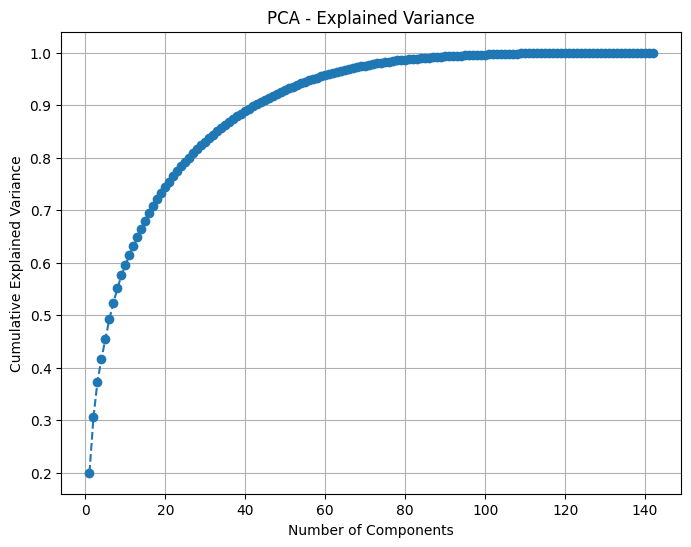

Number of components to explain 99.0% of the variance: 85


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_pca(data, threshold=0.99):

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    pca = PCA()
    pca.fit(data_scaled)

    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.title('PCA - Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    n_components = np.argmax(np.cumsum(explained_variance) >= threshold) + 1
    print(f'Number of components to explain {threshold*100}% of the variance: {n_components}')

    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_scaled)

    df_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(n_components)])

    return df_pca, n_components

df_pca, n_components = perform_pca(df_random_sample)


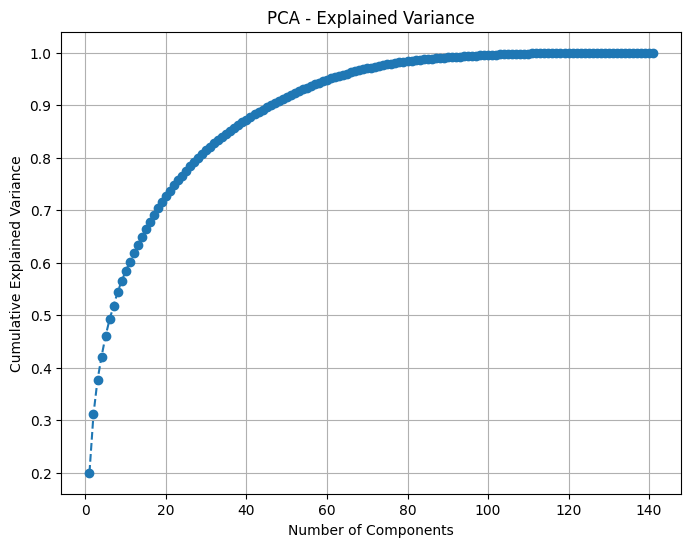

Number of components to explain 99.0% of the variance: 89


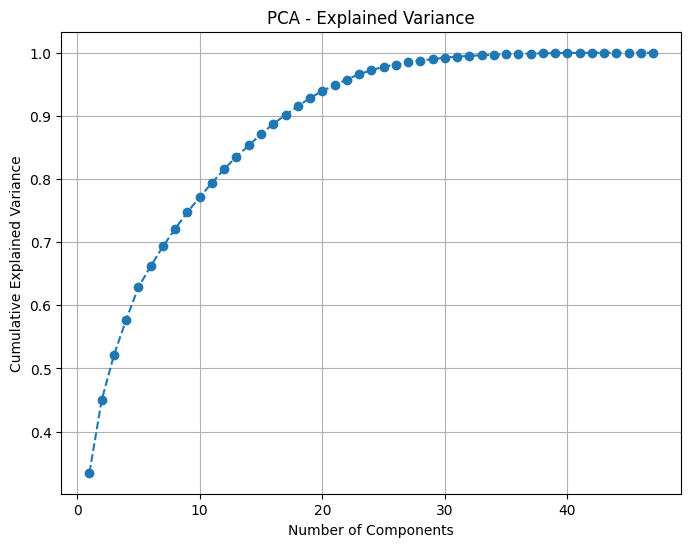

Number of components to explain 99.0% of the variance: 30


In [ ]:
combined_smartwatch_not_id_copy_highly_correlated_reducedlow_variance_pca, n_components_smartwatch = perform_pca(combined_smartwatch_not_id_copy_highly_correlated_reducedlow_variance)
combined_vicon_not_id_copy_highly_correlated_reducedlow_variance_pca, n_components_smartwatch = perform_pca(combined_vicon_not_id_copy_highly_correlated_reducedlow_variance)

#Preview what the data looks like

In [ ]:
df_random_sample = combined_smartwatch_not_id_copy_highly_correlated_reducedlow_variance.sample(n=1000, random_state=42)


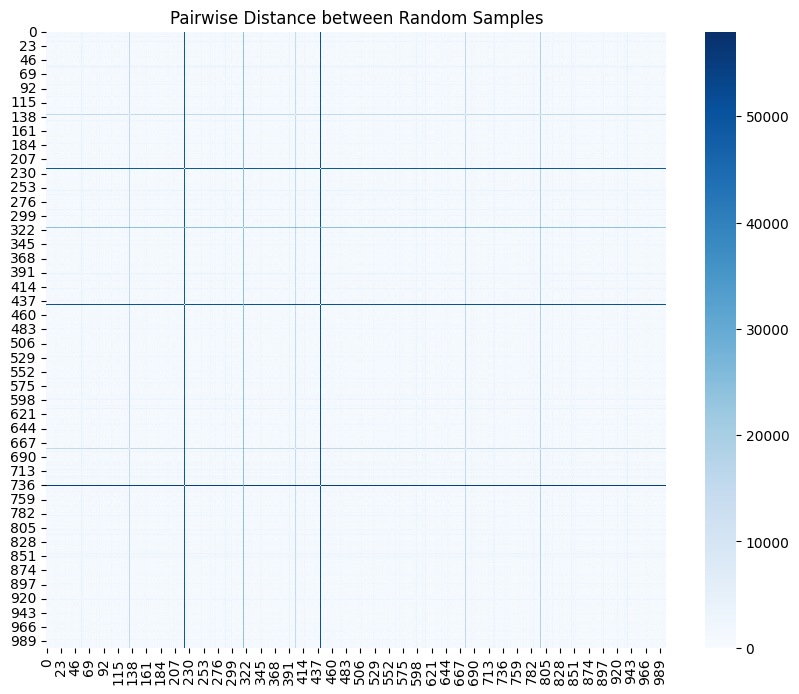

In [ ]:
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns


distance_matrix = pairwise_distances(df_random_sample, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap='Blues', annot=False)
plt.title('Pairwise Distance between Random Samples')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=18, random_state=42)
df_random_sample['Cluster'] = kmeans.fit_predict(df_random_sample)
df_random_sample['Cluster']
cluster_counts = df_random_sample['Cluster'].value_counts()
print(cluster_counts)
# plt.scatter(df_random_sample[:, 0], df_random_sample[:, 1], c=df_random_sample['Cluster'], cmap='viridis')
# plt.title("K-Means Clustering of Actions")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.show()


Cluster
3     166
15    124
6     124
12    107
7     106
0      93
17     67
8      67
10     46
5      44
14     23
16     19
13      4
2       3
1       3
9       2
11      1
4       1
Name: count, dtype: int64


#filter ANOVA

In [ ]:
from scipy import stats

def anova_all_columns(df, cluster_column='Cluster'):
    results = {}

    columns = [col for col in df.columns if col != cluster_column]

    for column in columns:
        groups = [df[df[cluster_column] == i][column] for i in df[cluster_column].unique()]

        f_statistic, p_value = stats.f_oneway(*groups)

        results[column] = {'F-statistic': f_statistic, 'P-value': p_value}

    return results

anova_results = anova_all_columns(df_random_sample)

for column, result in anova_results.items():
    print(f"Column: {column}")
    print(f"F-statistic: {result['F-statistic']}")
    print(f"P-value: {result['P-value']}")
    if result['P-value'] < 0.05:
        print("There is a significant difference between the groups\n")
    else:
        print("There is no significant difference between the groups\n")



In [ ]:
from scipy import stats

def filter_significant_columns(df, cluster_column='Cluster', alpha=0.05):
    significant_columns = [cluster_column]
    columns = [col for col in df.columns if col != cluster_column]
    for column in columns:
        groups = [df[df[cluster_column] == i][column] for i in df[cluster_column].unique()]
        f_statistic, p_value = stats.f_oneway(*groups)
        if p_value < alpha:
            significant_columns.append(column)

    return df[significant_columns]

df_filtered = filter_significant_columns(df_random_sample)

print(df_filtered)


#*Reunion back*

In [ ]:
combined_smartwatch_df_final = pd.concat([combined_smartwatch_df_copy[['id']], combined_smartwatch_not_id_copy_highly_correlated_reducedlow_variance], axis=1)
combined_vicon_df_final = pd.concat([combined_vicon_df_copy[['id']], combined_vicon_not_id_copy_highly_correlated_reducedlow_variance], axis=1)

vicon_train_x = pd.merge(combined_vicon_df_final, df_vicon[['id', 'activity']], on='id', how='inner')
trian_smartwatch_stas = pd.merge(combined_smartwatch_df_final, df_smartwatch[['id', 'activity']], on='id', how='inner')

vicon_matadata_x = pd.merge(combined_vicon_df_final, df_metadata_vicon, left_on='id', right_on='sample_id', how='inner')
smartwatch_matadata_x = pd.merge(combined_smartwatch_df_final, df_metadata_smartwatch, left_on='id', right_on='sample_id', how='inner')
vicon_matadata_x = vicon_matadata_x.drop(columns=['sample_id', 'body_part', 'side', 'sequence_length'])
smartwatch_matadata_x= smartwatch_matadata_x.drop(columns=['sample_id', 'body_part', 'side', 'sequence_length'])


#Using a random forest model to find parameters

Smartwatch Model Performance:
Accuracy: 0.9914

Confusion Matrix:
[[220   0   1   0   0   0   0   0   0   0   0   0   0   0   2   0   2   0]
 [  0 358   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0 326   1   0   0   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   1   0 376   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 251   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 165   0   0   1   0   0   0   0   0   0   0   3]
 [  0   0   0   0   0   0   0 575   0   2   0   1   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0 364   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 616   0   1   0   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0   1   0 581   0   0   0   0   0   0   0]
 [  1   1   0   0   0   0   0   2   0   9   0 590   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0 

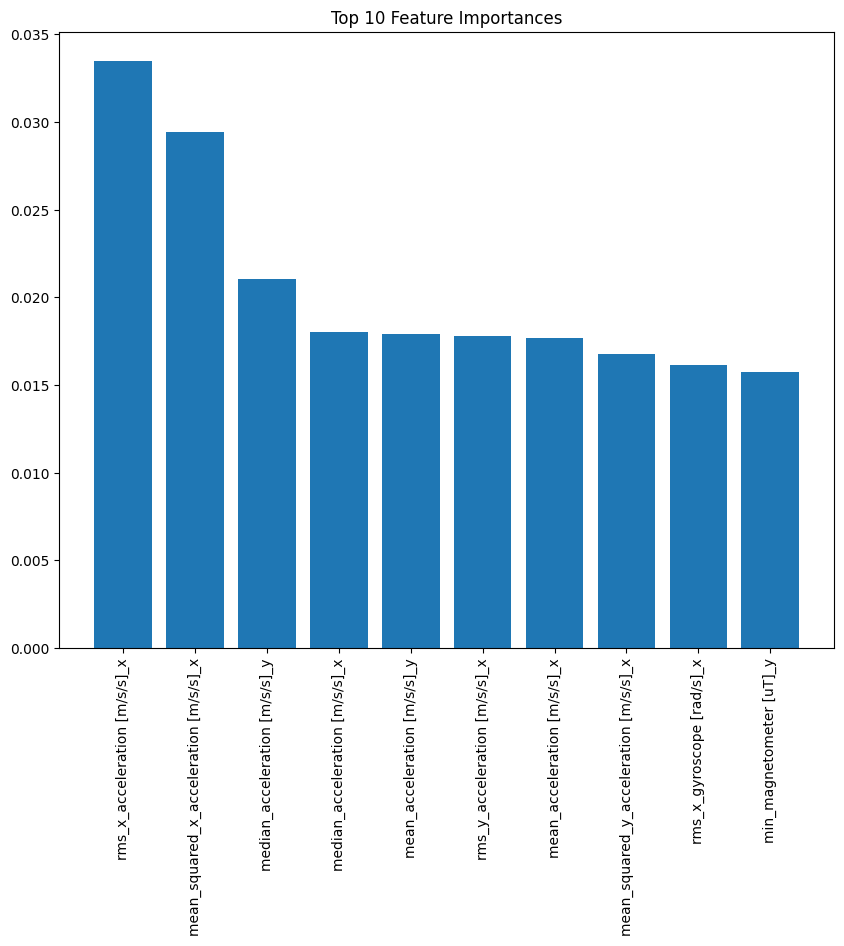

,rms_x_acceleration [m/s/s]_x,mean_squared_x_acceleration [m/s/s]_x,median_acceleration [m/s/s]_y,median_acceleration [m/s/s]_x,mean_acceleration [m/s/s]_y,rms_y_acceleration [m/s/s]_x,mean_acceleration [m/s/s]_x,mean_squared_y_acceleration [m/s/s]_x,rms_x_gyroscope [rad/s]_x,min_magnetometer [uT]_y,...,time_to_peak_x_acceleration [m/s/s]_x,time_to_peak_x_magnetometer [uT]_x,time_to_peak_z_acceleration [m/s/s]_x,time_to_peak_y_gyroscope [rad/s]_x,time_to_peak_z_gyroscope [rad/s]_x,time_to_peak_y_acceleration [m/s/s]_x,time_to_peak_x_gyroscope [rad/s]_x,time_to_peak_y_magnetometer [uT]_x,peak_count_y_magnetometer [uT]_x,peak_count_x_magnetometer [uT]_x
0,9.342803,87.287971,-5.136752,-4.050039,-4.627377,8.508433,-5.130461,72.393435,3.792402,-36.752500,...,0.298211,0.616617,0.454274,0.392965,0.447236,0.431412,0.625126,0.439439,214.0,219.0
1,7.835317,61.392197,-8.420826,-3.968655,-6.933920,9.621873,-5.094057,92.580449,3.377513,-32.543500,...,0.136318,0.215431,0.054726,0.100301,0.048144,0.031841,0.225677,0.038076,243.0,242.0
2,4.506438,20.307981,-8.708063,-2.704813,-8.276178,8.770944,-3.186712,76.929456,1.863221,-31.933500,...,0.772908,0.016000,0.025896,0.078313,0.060241,0.024900,0.025100,0.763000,282.0,270.0
3,3.240252,10.499230,-8.880404,-2.800559,-8.826133,8.897377,-2.693206,79.163320,0.737078,21.380500,...,0.572428,0.017964,0.733267,0.199599,0.781344,0.133866,0.164493,0.563872,292.0,269.0
4,3.520401,12.393221,-9.000086,-3.408544,-8.856392,8.936400,-2.984841,79.859250,0.733194,22.600500,...,0.372255,0.069930,0.532934,0.000000,0.581745,0.823353,0.186560,0.363636,289.0,277.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36181,0.806801,0.650928,-7.865501,-0.636708,-7.883121,7.902804,-0.703145,62.454317,0.166817,48.403500,...,0.327082,0.309077,0.378095,0.304348,0.303598,0.378095,0.328336,0.341335,373.0,373.0
36182,0.794000,0.630437,-7.913374,-0.636708,-7.917799,7.936818,-0.693355,62.993073,0.165540,48.403500,...,0.177044,0.159040,0.228057,0.154423,0.153673,0.228057,0.178411,0.191298,380.0,376.0
36183,0.771352,0.594984,-7.961247,-0.627134,-7.952865,7.969994,-0.673107,63.520806,0.152935,48.983000,...,0.027007,0.009002,0.078020,0.004498,0.003748,0.078020,0.028486,0.041260,371.0,377.0
36184,0.831314,0.691083,-7.961247,-0.636708,-7.884715,7.956024,-0.638985,63.298314,0.321862,36.996502,...,0.972993,0.990998,0.942236,0.955772,0.982759,0.990998,0.976012,0.489122,368.0,372.0


In [ ]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Merge Smartwatch Features and Labels
# df_smartwatch_final = pd.merge(trian_smartwatch_stas, df_smartwatch_y, on='id')

# Split Smartwatch Data into Features (X) and Target (y)
X_smartwatch = trian_smartwatch_stas.drop(columns=['id', 'activity'])  # Exclude 'id' and 'activity'
y_smartwatch = trian_smartwatch_stas['activity']  # The target column
print(X_smartwatch)
# X_smartwatch = X_smartwatch[smart_watch_top_30_features[:90]]
# 5. Encoding the Target Labels (Activities) as Numeric Values
le = LabelEncoder()
y_smartwatch = le.fit_transform(y_smartwatch)
scaler = StandardScaler()
X_smartwatch_norm = scaler.fit_transform(X_smartwatch)

# Train-Test Split (80% training, 20% testing)
X_smartwatch_train, X_smartwatch_test, y_smartwatch_train, y_smartwatch_test = train_test_split(X_smartwatch_norm, y_smartwatch, test_size=0.2, random_state=42)

# Train Random Forest Model for Smartwatch
rf_smartwatch = RandomForestClassifier(
    n_estimators=300,          # Number of trees (added more trees)
    random_state=42,           # To ensure reproducibility
    criterion='entropy',       # Use entropy instead of gini (improves splits)
    max_features='log2',      # Use square root of total features to reduce overfitting
)

rf_smartwatch.fit(X_smartwatch_train, y_smartwatch_train)


# Predict and Evaluate Smartwatch Model
y_smartwatch_pred = rf_smartwatch.predict(X_smartwatch_test)
print("Smartwatch Model Performance:")
print(f"Accuracy: {accuracy_score(y_smartwatch_test, y_smartwatch_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_smartwatch_test, y_smartwatch_pred))
print("\nClassification Report:")
print(classification_report(y_smartwatch_test, y_smartwatch_pred, target_names=le.classes_))

y_val_pred_proba_smartwatch = rf_smartwatch.predict_proba(X_smartwatch_test)

# Calculate log loss on the validation set
logloss_smartwatch = log_loss(y_smartwatch_test, y_val_pred_proba_smartwatch)
print(f'Log Loss on Validation Set: {logloss_smartwatch}')

import matplotlib.pyplot as plt
import numpy as np

feature_importances = rf_smartwatch.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

print("Top 10 Features:")
for i in range(10):
    print(f"{X_smartwatch.columns[sorted_indices[i]]}: {feature_importances[sorted_indices[i]]:.4f}")

plt.figure(figsize=(10, 8))
plt.bar(range(10), feature_importances[sorted_indices[:10]], align="center")
plt.xticks(range(10), X_smartwatch.columns[sorted_indices[:10]], rotation=90)
plt.title("Top 10 Feature Importances")
plt.show()
sorted_indices = np.argsort(feature_importances)[::-1]

smart_watch_top_30_indices = sorted_indices
smart_watch_top_30_features = X_smartwatch.columns[smart_watch_top_30_indices]

X_smartwatch_top_30 = X_smartwatch[smart_watch_top_30_features]

X_smartwatch_top_30



# feature_importances = pd.Series(rf_smartwatch.feature_importances_, index=X_smartwatch.columns).sort_values(ascending=False)
# print("Feature Importance Scores:\n", feature_importances)

# important_features_smartwatch = feature_importances[feature_importances > 0.01].index
# X_important_smartwatch = X_smartwatch[important_features_smartwatch]
# X_important_smartwatch


Vicon Model Performance:
Accuracy: 0.9737

Confusion Matrix:
[[ 52   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 141   0   0   0   0   5   0   0   0   0   0   0   0   0   0]
 [  0   0 120   0   0   0   0   0   0   0   0   0   0   1   0   0]
 [  0   2   0 118   0   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0  46   0   1   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 269   0   3   0   0   0   2   0   0   0   0]
 [  0   4   0   0   0   0 146   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   4   0 295   2   6   3   1   0   0   0   0]
 [  0   0   0   0   0   2   0   0 308   0   1   1   0   0   0   0]
 [  0   0   0   0   0   0   0   3   2 279   4   4   0   0   0   0]
 [  0   0   0   0   0   0   0   3   4   6 250   1   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0 326   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 102   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 120   2   0]


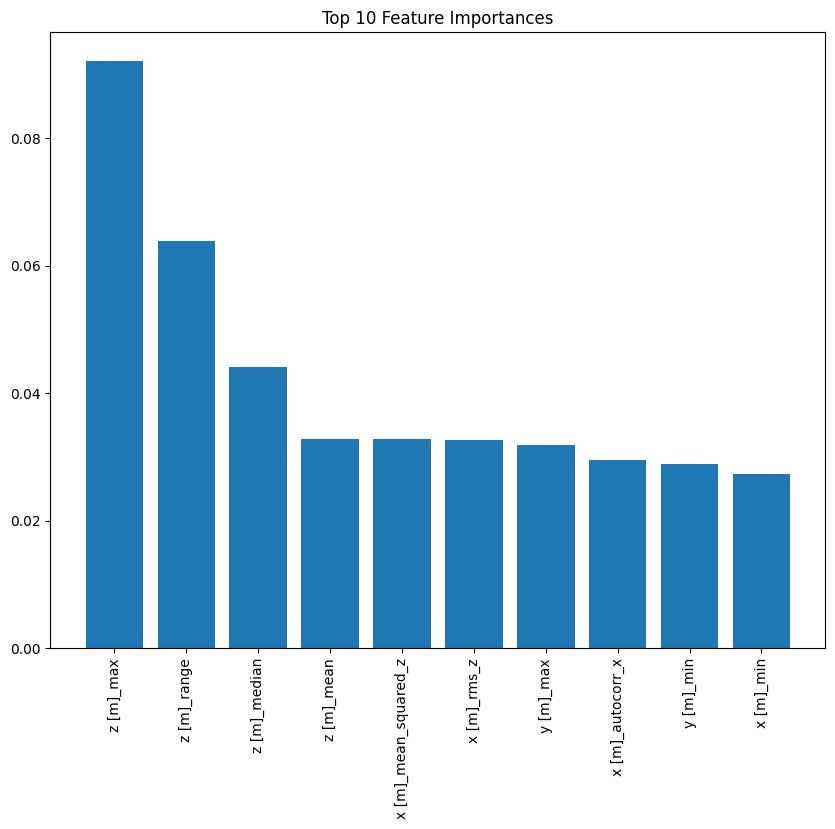

In [ ]:
# List of 16 activities for vicon
vicon_activities = [
    'brushing_teeth', 'idle', 'preparing_sandwich', 'reading_book',
    'typing', 'using_phone', 'using_remote_control', 'walking_freely',
    'walking_holding_a_tray', 'walking_with_handbag',
    'walking_with_hands_in_pockets', 'walking_with_object_underarm',
    'washing_face_and_hands', 'washing_mug', 'washing_plate',
    'writing'
]

# 1. Merge Vicon Features and Labels
# df_vicon_final = pd.merge(trian_vicon_stas, df_vicon_y, on='id')

# 2. Split Vicon Data into Features (X) and Target (y)
X_vicon = vicon_train_x.drop(columns=['id', 'activity'])  # Exclude 'id' and 'activity'
# X_vicon=X_vicon[vicon_top_30_features]
y_vicon = vicon_train_x['activity']  # The target column
# X_vicon = X_vicon[important_features_vicon]
# 3. Encoding the Target Labels (Activities) as Numeric Values for the 16 activities
# We only encode the activities that are in vicon_activities
le_vicon = LabelEncoder()
y_vicon = le_vicon.fit_transform(y_vicon)

# Ensure that the encoding has the correct labels
assert all([activity in vicon_activities for activity in le_vicon.classes_]), "Mismatch between encoded labels and vicon activities."

scaler = StandardScaler()
X_vicon_norm = scaler.fit_transform(X_vicon)

# 4. Train-Test Split (80% training, 20% testing) for Vicon
X_vicon_train, X_vicon_test, y_vicon_train, y_vicon_test = train_test_split(X_vicon_norm, y_vicon, test_size=0.2, random_state=42)

# 5. Train Random Forest Model for Vicon
rf_vicon = RandomForestClassifier(n_estimators=200,random_state=42)
rf_vicon.fit(X_vicon_train, y_vicon_train)

# 6. Predict and Evaluate Vicon Model
y_vicon_pred = rf_vicon.predict(X_vicon_test)
print("\nVicon Model Performance:")
print(f"Accuracy: {accuracy_score(y_vicon_test, y_vicon_pred):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_vicon_test, y_vicon_pred))
print("\nClassification Report:")
print(classification_report(y_vicon_test, y_vicon_pred, target_names=vicon_activities))


import matplotlib.pyplot as plt
import numpy as np

feature_importances = rf_vicon.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]

print("Top 10 Features:")
for i in range(10):
    print(f"{X_vicon.columns[sorted_indices[i]]}: {feature_importances[sorted_indices[i]]:.4f}")

plt.figure(figsize=(10, 8))
plt.bar(range(10), feature_importances[sorted_indices[:10]], align="center")
plt.xticks(range(10), X_vicon.columns[sorted_indices[:10]], rotation=90)
plt.title("Top 10 Feature Importances")
plt.show()
sorted_indices = np.argsort(feature_importances)[::-1]

vicon_top_30_indices = sorted_indices
vicon_top_30_features = X_vicon.columns[vicon_top_30_indices]



# feature_importances = pd.Series(rf_vicon.feature_importances_, index=X_vicon.columns).sort_values(ascending=False)
# print("Feature Importance Scores:\n", feature_importances)

# important_features_vicon = feature_importances[feature_importances > 0.01].index
# X_important_vicon = X_vicon[important_features_vicon]
# X_important_vicon


#to submsiv

In [ ]:
# merged_smartwatch_df = pd.merge(trian_smartwatch_stas, df_train_smartwatch_copy[['id', 'activity']], on='id', how='left')
# merged_vicon_df = pd.merge(trian_vicon_stas, df_train_vicon_copy[['id', 'activity']], on='id', how='left')
smartwatch_matadata_x_copy = smartwatch_matadata_x.copy()
smartwatch_matadata_x_copy = smartwatch_matadata_x_copy.drop(columns=['id'])
vicon_matadata_x_copy = vicon_matadata_x.copy()
vicon_matadata_x_copy = vicon_matadata_x_copy.drop(columns=['id'])
df_metadata_smartwatch = df_metadata_smartwatch_copy[['sample_id', 'body_part', 'side', 'sequence_length']]
df_metadata_smartwatch = df_metadata_smartwatch.sort_values(by=['sample_id'])
df_metadata_vicon = df_metadata_vicon_copy[['sample_id', 'body_part', 'side', 'sequence_length']]
df_metadata_vicon = df_metadata_vicon.sort_values(by=['sample_id'])




In [ ]:
X_train_vicon = vicon_train_x.drop(columns=['activity', 'id'])
y_train_vicon = vicon_train_x['activity']

X_test_vicon = vicon_matadata_x.drop(columns=['id'])



X_train_smartwatch = trian_smartwatch_stas.drop(columns=['activity', 'id'])
y_train_smartwatch = trian_smartwatch_stas['activity']

X_test_smartwatch = smartwatch_matadata_x.drop(columns=['id'])


#Randomforset

In [ ]:
# Split the training data into train and validation sets
from sklearn.preprocessing import MinMaxScaler

# X_train = X_train[smart_watch_top_30_features]

scaler = MinMaxScaler() #this can change

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_smartwatch, y_train_smartwatch, test_size=0.2, random_state=42)


X_train_split = scaler.fit_transform(X_train_split)
X_val_split = scaler.transform(X_val_split)
# Initialize the model
model = RandomForestClassifier(n_estimators=200, random_state=42,criterion='entropy',max_features='log2')

# Train the model
model.fit(X_train_split, y_train_split)

# Predict probabilities for the validation set
y_val_pred_proba = model.predict_proba(X_val_split)

# Calculate log loss on the validation set
logloss = log_loss(y_val_split, y_val_pred_proba)
print(f'Log Loss on Validation Set: {logloss}')


X_test_norm=scaler.fit_transform(X_test_smartwatch)

y_test_pred_proba = model.predict_proba(X_test_norm)
y_test_pred_proba

Log Loss on Validation Set: 0.18006052989276836


array([[0.23 , 0.035, 0.06 , ..., 0.045, 0.08 , 0.01 ],
       [0.76 , 0.04 , 0.125, ..., 0.005, 0.005, 0.005],
       [0.73 , 0.05 , 0.12 , ..., 0.01 , 0.005, 0.005],
       ...,
       [0.01 , 0.   , 0.   , ..., 0.   , 0.   , 0.005],
       [0.01 , 0.005, 0.005, ..., 0.   , 0.   , 0.   ],
       [0.01 , 0.   , 0.005, ..., 0.   , 0.   , 0.005]])

In [ ]:
# # X_test= X_test[smart_watch_top_30_features[:90]]
# X_test=scaler.fit_transform(X_test_smartwatch)

# y_test_pred_proba = model.predict_proba(X_test_smartwatch)
# y_test_pred_proba

In [ ]:
# Split the training data into train and validation sets
# X_train_vicon = X_train_vicon[vicon_top_30_features[:20]]
X_train_split_vicon, X_val_split_vicon, y_train_split_vicon, y_val_split_vicon = train_test_split(X_train_vicon, y_train_vicon, test_size=0.2, random_state=42)

scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and validation sets
X_train_split_vicon = scaler.fit_transform(X_train_split_vicon)
X_val_split_vicon = scaler.transform(X_val_split_vicon)

# Initialize the model
model_vicon = RandomForestClassifier(n_estimators=200, random_state=42,criterion='entropy',max_features='log2')

# Train the model
model_vicon.fit(X_train_split_vicon, y_train_split_vicon)

# Predict probabilities for the validation set
y_val_pred_proba_vicon = model_vicon.predict_proba(X_val_split_vicon)

# Calculate log loss on the validation set
logloss_vicon = log_loss(y_val_split_vicon, y_val_pred_proba_vicon)
print(f'Log Loss on Validation Set: {logloss_vicon}')
# X_test_vicon = X_test_vicon[vicon_top_30_features[:20]]
X_test_vicon_norm = scaler.fit_transform(X_test_vicon)

y_test_pred_proba_vicon = model_vicon.predict_proba(X_test_vicon_norm)

Log Loss on Validation Set: 0.25933400372180143


#MLP

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming X_train, X_test, and y_train are already defined

# Initialize the scaler
scaler = MinMaxScaler()

# Split the data into train and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# # Scale the train and validation sets using the scaler fitted on the training set
X_train_split = scaler.fit_transform(X_train_split)  # Fit on the training set
X_val_split = scaler.transform(X_val_split)          # Use the same scaler to transform validation set

# Initialize the MLP model (Multi-layer Perceptron)
model = MLPClassifier(
    hidden_layer_sizes=(64, 128),  # Two hidden layers with 100 and 50 neurons respectively
    activation='relu',             # Using ReLU activation function
    solver='adam',                 # Adam optimizer
    max_iter=600,                  # Maximum number of iterations
    random_state=42               # For reproducibility
    # verbose=True,                  # Display training progress
    # early_stopping=True,           # Stop early if validation score is not improving
    # n_iter_no_change=50,            # Stop after 10 iterations without improvement
)

le = LabelEncoder()
y_train_split = le.fit_transform(y_train_split)
y_val_split = le.transform(y_val_split)

# y_train_split = y_train_split.astype(int)  # Or the appropriate numeric type
# y_val_split = y_val_split.astype(int)
# Train the MLP model
model.fit(X_train_split, y_train_split)

# Predict probabilities for the validation set
y_val_pred_proba = model.predict_proba(X_val_split)

# Calculate log loss on the validation set
logloss = log_loss(y_val_split, y_val_pred_proba)
print(f'Log Loss on Validation Set: {logloss}')

# Now scale the test set using the scaler that was fitted on the training set
X_test = scaler.transform(X_test)  # Transform the test set using the fitted scaler

# Predict probabilities for the test set
y_test_pred_proba = model.predict_proba(X_test)

# The predicted probabilities for the test set are stored in y_test_pred_proba
print(f'Predicted Probabilities for Test Set: {y_test_pred_proba}')


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Assuming X_train_vicon, X_test_vicon, y_train_vicon are already defined
# X_train_vicon = X_train_vicon[vicon_top_30_features[:20]]

# Split the data into train and validation sets for Vicon data
X_train_split_vicon, X_val_split_vicon, y_train_split_vicon, y_val_split_vicon = train_test_split(
    X_train_vicon, y_train_vicon, test_size=0.2, random_state=42
)

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and validation sets
X_train_split_vicon = scaler.fit_transform(X_train_split_vicon)  # Fit on the training data
X_val_split_vicon = scaler.transform(X_val_split_vicon)          # Transform the validation data

# Initialize the MLP model for Vicon data
model_vicon = MLPClassifier(
    hidden_layer_sizes=(64, 128),  # Two hidden layers with 100 and 50 neurons respectively
    activation='relu',             # Using ReLU activation function
    solver='adam',                 # Adam optimizer
    max_iter=600,                  # Maximum number of iterations
    random_state=42               # For reproducibility
    # verbose=True,                  # Display training progress
    # early_stopping=True,           # Stop early if validation score is not improving
    # n_iter_no_change=50            # Stop after 10 iterations without improvement
)


le = LabelEncoder()
y_train_split_vicon = le.fit_transform(y_train_split_vicon)
y_val_split_vicon = le.transform(y_val_split_vicon)
# Train the model on the training data
model_vicon.fit(X_train_split_vicon, y_train_split_vicon)

# Predict probabilities for the validation set
y_val_pred_proba_vicon = model_vicon.predict_proba(X_val_split_vicon)

# Calculate log loss on the validation set
logloss_vicon = log_loss(y_val_split_vicon, y_val_pred_proba_vicon)
print(f'Log Loss on Validation Set: {logloss_vicon}')
# X_test_vicon = X_test_vicon[vicon_top_30_features[:60]]
# Now scale the test set using the same scaler fitted on the training data
X_test_vicon = scaler.transform(X_test_vicon)  # Transform the test data using the fitted scaler

# Predict probabilities for the test set
y_test_pred_proba_vicon = model_vicon.predict_proba(X_test_vicon)

# The predicted probabilities for the test set are stored in y_test_pred_proba_vicon
print(f'Predicted Probabilities for Test Set: {y_test_pred_proba_vicon}')



#to fixit  

In [ ]:
# Columns based on your activity names
columns = [
    'sample_id', 'brushing_teeth', 'idle', 'preparing_sandwich', 'reading_book',
    'stairs_down', 'stairs_up', 'typing', 'using_phone', 'using_remote_control',
    'walking_freely', 'walking_holding_a_tray', 'walking_with_handbag', 'walking_with_hands_in_pockets',
    'walking_with_object_underarm', 'washing_face_and_hands', 'washing_mug', 'washing_plate', 'writing'
]

# Assuming y_test_pred_proba is the array of probabilities and test_smartwatch_df is your test DataFrame
# Extract the sample_ids from the test data
sample_ids = matadata_smartwatch_stas['id'].values

# Convert the probabilities to a DataFrame with the correct column names
y_test_pred_proba_df = pd.DataFrame(y_test_pred_proba, columns=columns[1:])  # Skip the 'sample_id' column for now
y_test_pred_proba_df['sample_id'] = sample_ids  # Add the sample_id column

# Reorder the columns so 'sample_id' is the first column
y_test_pred_proba_df = y_test_pred_proba_df[columns]

# Display the resulting DataFrame
print(y_test_pred_proba_df.head())


   sample_id  brushing_teeth   idle  preparing_sandwich  reading_book  \
0          1           0.230  0.035               0.060         0.015   
1          9           0.760  0.040               0.125         0.010   
2         12           0.730  0.050               0.120         0.015   
3         16           0.735  0.045               0.120         0.020   
4         17           0.750  0.045               0.125         0.010   

   stairs_down  stairs_up  typing  using_phone  using_remote_control  \
0        0.000      0.000   0.005        0.105                 0.040   
1        0.000      0.000   0.000        0.005                 0.015   
2        0.000      0.000   0.000        0.000                 0.015   
3        0.005      0.005   0.005        0.000                 0.025   
4        0.005      0.010   0.010        0.000                 0.020   

   walking_freely  walking_holding_a_tray  walking_with_handbag  \
0            0.06                   0.040                  0.

In [ ]:
# Columns based on your activity names
columns = [
    'sample_id', 'brushing_teeth', 'idle', 'preparing_sandwich', 'reading_book',
    'typing', 'using_phone', 'using_remote_control',
    'walking_freely', 'walking_holding_a_tray', 'walking_with_handbag', 'walking_with_hands_in_pockets',
    'walking_with_object_underarm', 'washing_face_and_hands', 'washing_mug', 'washing_plate', 'writing'
]

# Assuming y_test_pred_proba is the array of probabilities and test_smartwatch_df is your test DataFrame
# Extract the sample_ids from the test data
sample_ids = matadata_vicon_stas['id'].values

# Convert the probabilities to a DataFrame with the correct column names
y_test_pred_proba_df_vicon = pd.DataFrame(y_test_pred_proba_vicon, columns=columns[1:])  # Skip the 'sample_id' column for now
y_test_pred_proba_df_vicon['sample_id'] = sample_ids  # Add the sample_id column

# Reorder the columns so 'sample_id' is the first column
y_test_pred_proba_df_vicon = y_test_pred_proba_df_vicon[columns]

# Display the resulting DataFrame
print(y_test_pred_proba_df_vicon.head())

   sample_id  brushing_teeth   idle  preparing_sandwich  reading_book  typing  \
0        258           0.340  0.040               0.150         0.050   0.010   
1        259           0.230  0.020               0.230         0.120   0.030   
2        269           0.430  0.045               0.140         0.050   0.010   
3        272           0.385  0.055               0.125         0.065   0.010   
4        276           0.300  0.020               0.075         0.040   0.005   

   using_phone  using_remote_control  walking_freely  walking_holding_a_tray  \
0          0.0                 0.020           0.005                     0.0   
1          0.0                 0.060           0.010                     0.0   
2          0.0                 0.020           0.005                     0.0   
3          0.0                 0.040           0.000                     0.0   
4          0.0                 0.105           0.005                     0.0   

   walking_with_handbag  walking

#concted btqwin table

In [ ]:
# Add 'stairs_down' and 'stairs_up' columns with value 0
y_test_pred_proba_df_vicon['stairs_down'] = 0
y_test_pred_proba_df_vicon['stairs_up'] = 0

# Display the updated DataFrame to verify the changes
print(y_test_pred_proba_df_vicon.head())

   sample_id  brushing_teeth   idle  preparing_sandwich  reading_book  typing  \
0        258           0.340  0.040               0.150         0.050   0.010   
1        259           0.230  0.020               0.230         0.120   0.030   
2        269           0.430  0.045               0.140         0.050   0.010   
3        272           0.385  0.055               0.125         0.065   0.010   
4        276           0.300  0.020               0.075         0.040   0.005   

   using_phone  using_remote_control  walking_freely  walking_holding_a_tray  \
0          0.0                 0.020           0.005                     0.0   
1          0.0                 0.060           0.010                     0.0   
2          0.0                 0.020           0.005                     0.0   
3          0.0                 0.040           0.000                     0.0   
4          0.0                 0.105           0.005                     0.0   

   walking_with_handbag  walking

In [ ]:
# Define the desired column order
columns = [
    'sample_id', 'brushing_teeth', 'idle', 'preparing_sandwich', 'reading_book',
    'stairs_down', 'stairs_up', 'typing', 'using_phone', 'using_remote_control',
    'walking_freely', 'walking_holding_a_tray', 'walking_with_handbag', 'walking_with_hands_in_pockets',
    'walking_with_object_underarm', 'washing_face_and_hands', 'washing_mug', 'washing_plate', 'writing'
]

# Reorganize the DataFrame columns
y_test_pred_proba_df_vicon = y_test_pred_proba_df_vicon[columns]

# Display the updated DataFrame to verify the changes
print(y_test_pred_proba_df_vicon.head())


   sample_id  brushing_teeth   idle  preparing_sandwich  reading_book  \
0        258           0.340  0.040               0.150         0.050   
1        259           0.230  0.020               0.230         0.120   
2        269           0.430  0.045               0.140         0.050   
3        272           0.385  0.055               0.125         0.065   
4        276           0.300  0.020               0.075         0.040   

   stairs_down  stairs_up  typing  using_phone  using_remote_control  \
0            0          0   0.010          0.0                 0.020   
1            0          0   0.030          0.0                 0.060   
2            0          0   0.010          0.0                 0.020   
3            0          0   0.010          0.0                 0.040   
4            0          0   0.005          0.0                 0.105   

   walking_freely  walking_holding_a_tray  walking_with_handbag  \
0           0.005                     0.0                  0.

In [ ]:
# Concatenate the two DataFrames along rows (axis=0)
concatenated_df = pd.concat([y_test_pred_proba_df_vicon, y_test_pred_proba_df], axis=0, ignore_index=True)

# Sort the concatenated DataFrame by 'sample_id'
concatenated_df = concatenated_df.sort_values(by='sample_id')

# Display the concatenated and sorted DataFrame
print(concatenated_df)
concatenated_df.to_csv('model1.csv', index=False)
# concatenated_df

files.download('model1.csv')


       sample_id  brushing_teeth   idle  preparing_sandwich  reading_book  \
22557          1           0.230  0.035               0.060         0.015   
22558          9           0.760  0.040               0.125         0.010   
22559         12           0.730  0.050               0.120         0.015   
22560         16           0.735  0.045               0.120         0.020   
22561         17           0.750  0.045               0.125         0.010   
...          ...             ...    ...                 ...           ...   
74739     124987           0.025  0.000               0.000         0.000   
74740     124988           0.015  0.000               0.000         0.000   
74741     124989           0.010  0.000               0.000         0.000   
74742     124990           0.010  0.005               0.005         0.000   
74743     124991           0.010  0.000               0.005         0.000   

       stairs_down  stairs_up  typing  using_phone  using_remote_control  \

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
concatenated_df

,sample_id,brushing_teeth,idle,preparing_sandwich,reading_book,stairs_down,stairs_up,typing,using_phone,using_remote_control,walking_freely,walking_holding_a_tray,walking_with_handbag,walking_with_hands_in_pockets,walking_with_object_underarm,washing_face_and_hands,washing_mug,washing_plate,writing
22557,1,0.075,0.035,0.035,0.035,0.005,0.000,0.025,0.045,0.040,0.020,0.020,0.050,0.060,0.130,0.135,0.095,0.085,0.110
22558,9,0.050,0.065,0.030,0.010,0.015,0.005,0.015,0.075,0.055,0.080,0.010,0.050,0.055,0.025,0.200,0.110,0.110,0.040
22559,12,0.065,0.075,0.045,0.005,0.010,0.010,0.020,0.065,0.055,0.060,0.010,0.060,0.050,0.050,0.175,0.120,0.085,0.040
22560,16,0.080,0.030,0.035,0.010,0.010,0.010,0.030,0.065,0.050,0.055,0.010,0.040,0.050,0.045,0.180,0.150,0.105,0.045
22561,17,0.070,0.030,0.045,0.010,0.015,0.010,0.020,0.070,0.045,0.045,0.005,0.035,0.035,0.030,0.220,0.170,0.090,0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74739,124987,0.035,0.020,0.010,0.040,0.055,0.050,0.015,0.055,0.035,0.075,0.025,0.050,0.050,0.085,0.140,0.135,0.070,0.055
74740,124988,0.045,0.025,0.015,0.045,0.065,0.050,0.020,0.055,0.035,0.075,0.015,0.070,0.040,0.080,0.125,0.135,0.060,0.045
74741,124989,0.055,0.025,0.015,0.050,0.060,0.040,0.015,0.035,0.035,0.080,0.015,0.075,0.055,0.065,0.125,0.135,0.065,0.055
74742,124990,0.045,0.025,0.010,0.035,0.055,0.050,0.005,0.050,0.030,0.085,0.020,0.060,0.055,0.080,0.125,0.140,0.060,0.070
